In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel, LdaSeqModel
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from konlpy.tag import Okt

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
print(len(newsgroups_train.data))

3219


In [3]:
def my_tokenizer(doc):
    tokens = RegexpTokenizer(r"[\w']+").tokenize(doc)
    return [WordNetLemmatizer().lemmatize(token) for token in tokens if len(token) > 1]

In [4]:
cv = CountVectorizer(tokenizer=my_tokenizer, max_features=2000, min_df=3, max_df=0.5, stop_words='english')
review_cv = cv.fit_transform(newsgroups_train.data)
review_cv.shape

c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(3219, 2000)

In [5]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', n_jobs=-1, random_state=0)
review_topics = lda.fit_transform(review_cv)
review_topics.shape

(3219, 10)

In [6]:
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}: {', '.join([feature_names[i] for i in topic.argsort()[:-(n_top_words+1):-1]])}")
    print()

In [7]:
print_top_words(lda, cv.get_feature_names_out())

Topic #0: space, nasa, wa, gov, year, launch, orbit, earth, satellite, access
Topic #1: key, chip, clipper, encryption, government, com, phone, escrow, law, use
Topic #2: wa, god, people, say, ha, jesus, don't, christian, thing, believe
Topic #3: key, information, public, message, faq, internet, mail, list, computer, anonymous
Topic #4: scsi, card, bus, ide, bit, driver, mode, drive, speed, work
Topic #5: com, posting, nntp, host, university, article, know, i'm, ca, thanks
Topic #6: com, article, au, sandvik, apple, wa, cc, kent, islam, muslim
Topic #7: drive, db, disk, problem, ___, hard, com, work, port, floppy
Topic #8: com, don't, think, morality, keith, article, moral, sgi, say, caltech
Topic #9: image, file, program, graphic, available, software, data, format, ftp, color



In [8]:
def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components=i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

n_components: 6, perplexity: 1012.430
n_components: 7, perplexity: 1005.217
n_components: 8, perplexity: 1006.676
n_components: 9, perplexity: 973.813
n_components: 10, perplexity: 975.659
n_components: 11, perplexity: 972.323
n_components: 12, perplexity: 970.600
n_components: 13, perplexity: 969.639
n_components: 14, perplexity: 972.125
n_components: 15, perplexity: 977.948


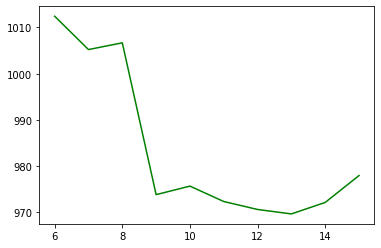

13

In [9]:
show_perplexity(review_cv, start=6, end=15)

In [10]:
lda = LatentDirichletAllocation(n_components=13, max_iter=5,
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', n_jobs=-1, random_state=0)
review_topics = lda.fit_transform(review_cv)
review_topics.shape

(3219, 13)

In [11]:
print_top_words(lda, cv.get_feature_names_out(), 15)

Topic #0: com, clipper, access, government, phone, chip, netcom, just, article, right, pat, digex, ti, wa, good
Topic #1: university, point, posting, thanks, nntp, host, problem, help, monitor, looking, i'm, know, just, graphic, cc
Topic #2: nasa, gov, year, research, cost, center, station, space, program, university, wa, billion, money, technology, news
Topic #3: key, encryption, chip, use, public, security, privacy, law, information, clipper, message, bit, ha, government, number
Topic #4: scsi, card, bus, ide, bit, driver, mode, memory, drive, pc, speed, controller, video, o, 16
Topic #5: ca, com, posting, nntp, host, version, know, newsreader, tin, ha, i'm, wrote, university, need, robert
Topic #6: com, article, c, au, sandvik, ibm, apple, kent, net, university, wa, posting, newton, cc, i'm
Topic #7: drive, db, disk, hard, ___, port, floppy, modem, __, work, com, controller, bios, card, problem
Topic #8: article, uk, ac, posting, nntp, host, wa, university, like, just, henry, toront

In [13]:
english_stops = set(stopwords.words('english'))

In [14]:
def my_tokenizer(doc):
    tokens = RegexpTokenizer(r"[\w']{2,}").tokenize(doc.lower())
    return [token for token in tokens if (token not in english_stops) and len(token) > 2]

In [15]:
texts = [my_tokenizer(news) for news in newsgroups_train.data]

In [16]:
dic = Dictionary(texts)
dic.filter_extremes(keep_n=5000, no_below=3, no_above=0.5)
print(len(dic))

5000


In [17]:
corpus = [dic.doc2bow(text) for text in texts]
print('Unique tokens', len(dic), '\n\n', 'Documents', len(corpus))

Unique tokens 5000 

 Documents 3219


In [18]:
model = LdaModel(corpus=corpus, id2word=dic, passes=5, num_topics=10, random_state=7)
model.print_topics(num_words=10)

[(0,
  '0.011*"one" + 0.010*"god" + 0.008*"people" + 0.007*"would" + 0.007*"think" + 0.007*"keith" + 0.006*"atheists" + 0.006*"atheism" + 0.006*"say" + 0.005*"moral"'),
 (1,
  '0.013*"drive" + 0.013*"scsi" + 0.011*"com" + 0.008*"card" + 0.007*"one" + 0.007*"would" + 0.007*"ide" + 0.006*"controller" + 0.006*"university" + 0.006*"get"'),
 (2,
  '0.019*"com" + 0.010*"netcom" + 0.010*"would" + 0.008*"key" + 0.008*"clipper" + 0.008*"article" + 0.008*"one" + 0.007*"escrow" + 0.007*"chip" + 0.007*"nsa"'),
 (3,
  '0.026*"key" + 0.009*"one" + 0.008*"bit" + 0.008*"number" + 0.007*"keys" + 0.007*"chip" + 0.007*"des" + 0.006*"algorithm" + 0.006*"bits" + 0.006*"use"'),
 (4,
  '0.024*"com" + 0.010*"would" + 0.010*"posting" + 0.008*"article" + 0.008*"nntp" + 0.008*"host" + 0.008*"university" + 0.007*"like" + 0.007*"i\'m" + 0.006*"know"'),
 (5,
  '0.012*"article" + 0.008*"university" + 0.007*"science" + 0.007*"posting" + 0.006*"com" + 0.006*"one" + 0.006*"nntp" + 0.006*"host" + 0.005*"theory" + 0.005*

In [21]:
model.get_document_topics(corpus)[1]

[(2, 0.055624876), (4, 0.8433068), (6, 0.07984084)]

In [22]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

num_topics: 6, perplexity: -7.714, coherence: -1.732
num_topics: 7, perplexity: -7.720, coherence: -1.685
num_topics: 8, perplexity: -7.693, coherence: -1.503
num_topics: 9, perplexity: -7.704, coherence: -1.579
num_topics: 10, perplexity: -7.706, coherence: -1.720
num_topics: 11, perplexity: -7.714, coherence: -1.805
num_topics: 12, perplexity: -7.732, coherence: -1.921
num_topics: 13, perplexity: -7.741, coherence: -2.185
num_topics: 14, perplexity: -7.750, coherence: -2.222
num_topics: 15, perplexity: -7.775, coherence: -1.843


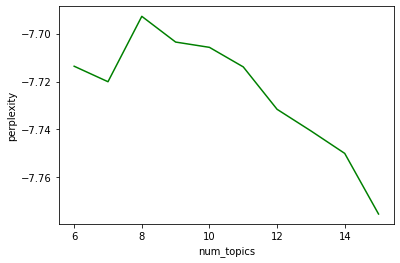

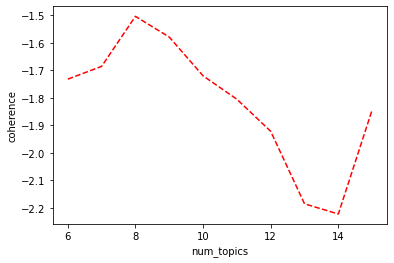

In [23]:
show_coherence(corpus=corpus, dictionary=dic)

In [24]:
model = LdaModel(corpus=corpus, id2word=dic, passes=5, num_topics=13, random_state=7)
model.print_topics(num_words=10)

[(0,
  '0.016*"god" + 0.011*"one" + 0.008*"atheism" + 0.008*"atheists" + 0.007*"moral" + 0.007*"people" + 0.007*"say" + 0.007*"believe" + 0.006*"morality" + 0.005*"must"'),
 (1,
  '0.015*"scsi" + 0.014*"drive" + 0.010*"com" + 0.009*"card" + 0.007*"ide" + 0.007*"one" + 0.007*"controller" + 0.007*"bus" + 0.006*"get" + 0.006*"disk"'),
 (2,
  '0.013*"com" + 0.011*"objective" + 0.010*"would" + 0.010*"one" + 0.010*"frank" + 0.009*"key" + 0.008*"article" + 0.008*"values" + 0.007*"good" + 0.007*"nsa"'),
 (3,
  '0.028*"key" + 0.011*"one" + 0.010*"bit" + 0.009*"number" + 0.007*"keys" + 0.007*"des" + 0.007*"bits" + 0.007*"chip" + 0.006*"use" + 0.006*"public"'),
 (4,
  '0.016*"university" + 0.015*"com" + 0.014*"posting" + 0.013*"nntp" + 0.013*"host" + 0.011*"thanks" + 0.010*"would" + 0.009*"i\'m" + 0.009*"know" + 0.008*"version"'),
 (5,
  '0.013*"article" + 0.009*"posting" + 0.009*"science" + 0.008*"com" + 0.008*"cwru" + 0.008*"nntp" + 0.008*"host" + 0.007*"university" + 0.007*"book" + 0.006*"one"

In [25]:
df = pd.read_csv("./data/petition_sampled.csv")
df.head()

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...
